# A Practical User Feedback Classifier for Software Quality Characteristics

This is a notebook that shows an application of the code available in the repository according to the article "*A Practical User Feedback Classifier for Software Quality Characteristics*" by Rubens dos Santos, Karina Villela, Diego Toralles Avila and Lucineia Heloisa Thom.

This code was used to classify requirements extracted from another model (RE-BERT). In order to do so, it was necessary to make some changes to the code to adapt it for this purpose, as the input and the treatment of data will be a little different from the original one.


In this case, a 10-fold Cross-Validation will be performed according to the article "RE-BERT: Automatic Extraction of Software Requirements from App Reviews using BERT Language Model" by Adailton Ferreira de Araújo and Ricardo Marcondes Marcacini. In addition, the dataset used will be the same as this article (RE-BERT).

The image below, taken from the article,  shows this strategy for a scenario involving reviews from 8 different mobile applications: 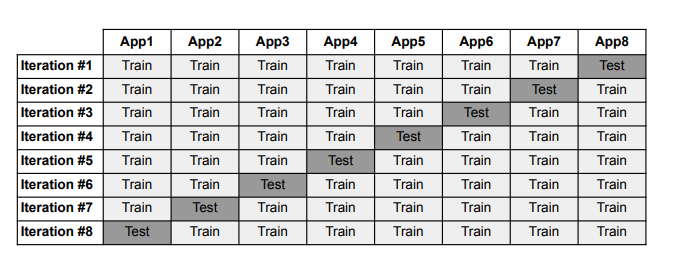

## Libraries

Importing the libraries needed.

In [ ]:
import pandas as pd
import numpy as np
import time

from imblearn.over_sampling import SMOTE

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import chi2
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier

from joblib import Parallel, delayed

In [ ]:
# Library used to save predictions in Google Drive
from google.colab import drive
drive.mount('/content/drive')
import shutil

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Global variables

These are the global variables used.

In [ ]:
TP_NB, TN_NB, FP_NB, FN_NB = 0, 0, 0, 0
TP_NBtf, TN_NBtf, FP_NBtf, FN_NBtf = 0, 0, 0, 0
TP_TREE, TN_TREE, FP_TREE, FN_TREE = 0, 0, 0, 0
TP_TREEtf, TN_TREEtf, FP_TREEtf, FN_TREEtf = 0, 0, 0, 0
TP_SVM, TN_SVM, FP_SVM, FN_SVM = 0, 0, 0, 0
TP_SVMtf, TN_SVMtf, FP_SVMtf, FN_SVMtf = 0, 0, 0, 0
TP_LR, TN_LR, FP_LR, FN_LR = 0, 0, 0, 0
TP_LRtf, TN_LRtf, FP_LRtf, FN_LRtf = 0, 0, 0, 0
TP_RF, TN_RF, FP_RF, FN_RF = 0, 0, 0, 0
TP_RFtf, TN_RFtf, FP_RFtf, FN_RFtf = 0, 0, 0, 0
TP_Grad, TN_Grad, FP_Grad, FN_Grad = 0, 0, 0, 0
TP_Gradtf, TN_Gradtf, FP_Gradtf, FN_Gradtf = 0, 0, 0, 0
#unigrams = []
pred_list = []
text_list = []

## Functions

The codes below show the functions used.

In [ ]:
def load_data(dataset, test):
    """Loads the dataset and returns a list of dataframes corresponding to each category and a list of classes.

    Keywords arguments:
    dataset -- dataset to be loaded
    test -- indicates if the data is for training or testing
    """
    df = pd.read_excel(dataset)

    if test == False: # train data
        df = df.drop(columns = ['Unnamed: 0', 'App', 'other'])
    else:             # test data
        df = df.drop(columns = ['Unnamed: 0', 'App', 'other', 'extracted'])

    df['Functional'].replace('x', '_Label_Func', inplace=True)
    df['Performance'].replace('x', '_Label_Perf', inplace=True)
    df['Compatibility'].replace('x', '_Label_Comp', inplace=True)
    df['Usability'].replace('x', '_Label_Usab', inplace=True)
    df.fillna('_Label_Zero', inplace=True)

    columns = list(df.columns.values)
    columns.remove('Text')

    functional_df = df.drop(columns=['Compatibility', 'Performance', 'Usability'])
    performance_df = df.drop(columns=['Compatibility', 'Functional', 'Usability'])
    compatibility_df = df.drop(columns=['Functional', 'Performance', 'Usability'])
    usability_df = df.drop(columns=['Compatibility', 'Performance', 'Functional'])

    functional_df.rename(columns={'Functional': 'Label',
                    'Performance': 'Label',
                    'Compatibility': 'Label',
                    'Usability': 'Label'},
           inplace=True)
    compatibility_df.rename(columns={'Functional': 'Label',
                    'Performance': 'Label',
                    'Compatibility': 'Label',
                    'Usability': 'Label'},
           inplace=True)
    usability_df.rename(columns={'Functional': 'Label',
                    'Performance': 'Label',
                    'Compatibility': 'Label',
                    'Usability': 'Label'},
           inplace=True)
    performance_df.rename(columns={'Functional': 'Label',
                    'Performance': 'Label',
                    'Compatibility': 'Label',
                    'Usability': 'Label'},
           inplace=True)

    dfs = []
    dfs.append(functional_df)
    dfs.append(performance_df)
    dfs.append(compatibility_df)
    dfs.append(usability_df)
    return dfs, columns

In [ ]:
def thread_code(df_train, df_test, costLearningWeight, FN):
    """Trains the models/algorithms using or not the balancing techniques and makes the predictions, updating the parameters of the Confusion Matrix.
    It is done for each iteration of the Cross-Validation (4 times per iteration as there are 4 classes).

    Keywords arguments:
    df_train -- dataset for training
    df_test -- dataset for testing
    costLearningWeight -- indicates if the balancing technique is Cost Sensitive Learning (CSL)
    FN -- number of false negatives from RE-BERT model
    """
    global TP_NB, TN_NB, FP_NB, FN_NB, TP_NBtf, TN_NBtf, FP_NBtf, FN_NBtf,TP_TREE, TN_TREE, FP_TREE, FN_TREE,TP_TREEtf, TN_TREEtf, FP_TREEtf, FN_TREEtf,TP_SVM, TN_SVM, FP_SVM, FN_SVM,TP_SVMtf, TN_SVMtf, FP_SVMtf, FN_SVMtf,TP_LR, TN_LR, FP_LR, FN_LR,TP_LRtf, TN_LRtf, FP_LRtf, FN_LRtf,TP_RF, TN_RF, FP_RF, FN_RF,TP_RFtf, TN_RFtf, FP_RFtf, FN_RFtf, TP_Grad, TN_Grad, FP_Grad, FN_Grad, TP_Gradtf, TN_Gradtf, FP_Gradtf, FN_Gradtf, pred_list, text_list #, unigrams

    label_0s = df_train.index[df_train['Label'] == '_Label_Zero'].tolist()  # contains indexes which column label matches label_zero
    label_relevants = df_train.index[df_train['Label'] != '_Label_Zero'].tolist()

    # Getting the texts and the labels
    corpus_train = list(df_train['Text'])
    corpus_test = list(df_test['Text'])
    labels_train = list(df_train['Label'])
    labels_test = list(df_test['Label'])

    # Bag of Words
    vectorizer = CountVectorizer(stop_words='english')
    bow_train = vectorizer.fit_transform(corpus_train)
    bow_train = bow_train.toarray()
    bow_test = vectorizer.transform(corpus_test)

    # Term Frequency - Inverse Document Frequency
    transformer = TfidfTransformer(smooth_idf=False)
    tfidf_train = transformer.fit_transform(bow_train)
    tfidf_train.toarray()
    tfidf_test = transformer.transform(bow_test)

    if (costLearningWeight == False):  # Using SMOTE:
        smote = SMOTE(k_neighbors=3)
        bow_train, labels_train_bow = smote.fit_resample(bow_train, labels_train)
        tfidf_train, labels_train_tf = smote.fit_resample(tfidf_train, labels_train)
    else:
        labels_train_bow = labels_train
        labels_train_tf = labels_train_bow
        '''
        # chi2 to select the best correlated terms
        features_chi2 = chi2(bow_train, labels_train_bow)
        indices = np.argsort(features_chi2[0])
        feature_names = np.array(vectorizer.get_feature_names())[indices]
        unigramst = [v for v in feature_names if len(v.split(' ')) == 1]
        unigrams.extend(unigramst[-5:])
        '''

    if (costLearningWeight != False):  # Using CostLearningWeight
        if(str(costLearningWeight) == "balanced"):
            weights = 'balanced'
        else:
            weights = {'_Label_Zero': 1, df_train.iloc[label_relevants[0]]['Label']: costLearningWeight}

        # train, predict and evaluate with Decision Tree - BOW
        TREE = tree.DecisionTreeClassifier(class_weight=weights)
        TREE.fit(bow_train, labels_train_bow)
        predictions = TREE.predict(bow_test)

        TP_TREEt, TN_TREEt, FP_TREEt, FN_TREEt = confusionMatrix(predictions, labels_test, FN)
        TP_TREE += TP_TREEt
        TN_TREE += TN_TREEt
        FP_TREE += FP_TREEt
        FN_TREE += FN_TREEt

        # train, predict and evaluate with Decision Tree - TFIDF
        TREE = tree.DecisionTreeClassifier(class_weight=weights)
        TREE.fit(tfidf_train, labels_train_tf)
        predictions = TREE.predict(tfidf_test)
        TP_TREEtft, TN_TREEtft, FP_TREEtft, FN_TREEtft = confusionMatrix(predictions, labels_test, FN)
        TP_TREEtf += TP_TREEtft
        TN_TREEtf += TN_TREEtft
        FP_TREEtf += FP_TREEtft
        FN_TREEtf += FN_TREEtft

        # train, predict and evaluate with SVM - BOW
        SVM = LinearSVC(class_weight=weights)
        SVM.fit(bow_train, labels_train_bow)
        predictions = SVM.predict(bow_test)
        TP_SVMt, TN_SVMt, FP_SVMt, FN_SVMt = confusionMatrix(predictions, labels_test, FN)
        TP_SVM += TP_SVMt
        TN_SVM += TN_SVMt
        FP_SVM += FP_SVMt
        FN_SVM += FN_SVMt

        # train, predict and evaluate with SVM - TFIDF
        SVM = LinearSVC(class_weight=weights)
        SVM.fit(tfidf_train, labels_train_tf)
        predictions = SVM.predict(tfidf_test)
        TP_SVMtft, TN_SVMtft, FP_SVMtft, FN_SVMtft = confusionMatrix(predictions, labels_test, FN)
        TP_SVMtf += TP_SVMtft
        TN_SVMtf += TN_SVMtft
        FP_SVMtf += FP_SVMtft
        FN_SVMtf += FN_SVMtft

        # train, predict and evaluate with Logistic Regression - BOW
        LR = LogisticRegression(random_state=0, class_weight=weights)
        LR.fit(bow_train, labels_train_bow)
        predictions = LR.predict(bow_test)
        TP_LRt, TN_LRt, FP_LRt, FN_LRt = confusionMatrix(predictions, labels_test, FN)
        TP_LR += TP_LRt
        TN_LR += TN_LRt
        FP_LR += FP_LRt
        FN_LR += FN_LRt

        # train, predict and evaluate with Logistic Regression - TFIDF
        LR = LogisticRegression(random_state=0, class_weight=weights)
        LR.fit(tfidf_train, labels_train_tf)
        predictions = LR.predict(tfidf_test)

        # saving predictions from the LR-TFIDF
        text_list.extend(corpus_test)
        pred_list.extend(predictions)

        TP_LRtft, TN_LRtft, FP_LRtft, FN_LRtft = confusionMatrix(predictions, labels_test, FN)
        TP_LRtf += TP_LRtft
        TN_LRtf += TN_LRtft
        FP_LRtf += FP_LRtft
        FN_LRtf += FN_LRtft
    else:
        # train, predict and evaluate with Multinomial Naive Bayes - BOW
        naive_bayes = MultinomialNB()
        naive_bayes.fit(bow_train, labels_train_bow)
        predictions = naive_bayes.predict(bow_test)
        TP_NBt, TN_NBt, FP_NBt, FN_NBt = confusionMatrix(predictions, labels_test, FN)
        TP_NB += TP_NBt
        TN_NB += TN_NBt
        FP_NB += FP_NBt
        FN_NB += FN_NBt

        # train, predict and evaluate with Multinomial Naive Bayes - TFIDF
        naive_bayes = MultinomialNB()
        naive_bayes.fit(tfidf_train, labels_train_tf)
        predictions = naive_bayes.predict(tfidf_test)
        TP_NBtft, TN_NBtft, FP_NBtft, FN_NBtft = confusionMatrix(predictions, labels_test, FN)
        TP_NBtf += TP_NBtft
        TN_NBtf += TN_NBtft
        FP_NBtf += FP_NBtft
        FN_NBtf += FN_NBtft

        # train, predict and evaluate with SVM - BOW
        SVM = LinearSVC()
        SVM.fit(bow_train, labels_train_bow)
        predictions = SVM.predict(bow_test)
        TP_SVMt, TN_SVMt, FP_SVMt, FN_SVMt = confusionMatrix(predictions, labels_test, FN)
        TP_SVM += TP_SVMt
        TN_SVM += TN_SVMt
        FP_SVM += FP_SVMt
        FN_SVM += FN_SVMt

        # train, predict and evaluate with SVM - TFIDF
        SVM = LinearSVC()
        SVM.fit(tfidf_train, labels_train_tf)
        predictions = SVM.predict(tfidf_test)
        TP_SVMtft, TN_SVMtft, FP_SVMtft, FN_SVMtft = confusionMatrix(predictions, labels_test, FN)
        TP_SVMtf += TP_SVMtft
        TN_SVMtf += TN_SVMtft
        FP_SVMtf += FP_SVMtft
        FN_SVMtf += FN_SVMtft

        # train, predict and evaluate with Logistic Regression - BOW
        LR = LogisticRegression(random_state=0)
        LR.fit(bow_train, labels_train_bow)
        predictions = LR.predict(bow_test)
        TP_LRt, TN_LRt, FP_LRt, FN_LRt = confusionMatrix(predictions, labels_test, FN)
        TP_LR += TP_LRt
        TN_LR += TN_LRt
        FP_LR += FP_LRt
        FN_LR += FN_LRt

        # train, predict and evaluate with Logistic Regression - TFIDF
        LR = LogisticRegression(random_state=0)
        LR.fit(tfidf_train, labels_train_tf)
        predictions = LR.predict(tfidf_test)
        TP_LRtft, TN_LRtft, FP_LRtft, FN_LRtft = confusionMatrix(predictions, labels_test, FN)
        TP_LRtf += TP_LRtft
        TN_LRtf += TN_LRtft
        FP_LRtf += FP_LRtft
        FN_LRtf += FN_LRtft

        # train, predict and evaluate with Random Forest - BOW
        RF = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)
        RF.fit(bow_train, labels_train_bow)
        predictions = RF.predict(bow_test)
        TP_RFt, TN_RFt, FP_RFt, FN_RFt = confusionMatrix(predictions, labels_test, FN)
        TP_RF += TP_RFt
        TN_RF += TN_RFt
        FP_RF += FP_RFt
        FN_RF += FN_RFt

        # train, predict and evaluate with Random Forest - TFIDF
        RF = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)
        RF.fit(tfidf_train, labels_train_tf)
        predictions = RF.predict(tfidf_test)
        TP_RFtft, TN_RFtft, FP_RFtft, FN_RFtft = confusionMatrix(predictions, labels_test, FN)
        TP_RFtf += TP_RFtft
        TN_RFtf += TN_RFtft
        FP_RFtf += FP_RFtft
        FN_RFtf += FN_RFtft

        # train, predict and evaluate with Gradient Boosting Classifier - BOW
        Grad = GradientBoostingClassifier()
        Grad.fit(bow_train, labels_train_tf)
        predictions = Grad.predict(bow_test)
        TP_Gradt, TN_Gradt, FP_Gradt, FN_Gradt = confusionMatrix(predictions, labels_test, FN)
        TP_Grad += TP_Gradt
        TN_Grad += TN_Gradt
        FP_Grad += FP_Gradt
        FN_Grad += FN_Gradt

        # train, predict and evaluate with Gradient Boosting Classifier - TFIDF
        Grad = GradientBoostingClassifier()
        Grad.fit(tfidf_train, labels_train_tf)
        predictions = Grad.predict(tfidf_test)
        TP_Gradtft, TN_Gradtft, FP_Gradtft, FN_Gradtft = confusionMatrix(predictions, labels_test, FN)
        TP_Gradtf += TP_Gradtft
        TN_Gradtf += TN_Gradtft
        FP_Gradtf += FP_Gradtft
        FN_Gradtf += FN_Gradtft

In [ ]:
def print_evaluation(dfs_train, dfs_test, classes, title, costLearningWeight, FN_from_others):
    """Organizes which dataset and data will be used for training and testing each time.
    Prints all the results: metrics of each model and the words most correlated to each category.

    Keywords arguments:
    dfs_train -- list of datasets for training
    dfs_test -- list of datasets for testing
    classes -- list of classes for classification
    title -- title for the files and indicates the model, balancing technique and app
    costLearningWeight -- indicates if the balancing technique is Cost Sensitive Learning (CSL)
    FN_from_others -- list that indicates the number of falses negatives from RE-BERT model for each class
    """
    global TP_NB, TN_NB, FP_NB, FN_NB, TP_NBtf, TN_NBtf, FP_NBtf, FN_NBtf,TP_TREE, TN_TREE, FP_TREE, FN_TREE,TP_TREEtf, TN_TREEtf, FP_TREEtf, FN_TREEtf,TP_SVM, TN_SVM, FP_SVM, FN_SVM,TP_SVMtf, TN_SVMtf, FP_SVMtf, FN_SVMtf,TP_LR, TN_LR, FP_LR, FN_LR,TP_LRtf, TN_LRtf, FP_LRtf, FN_LRtf,TP_RF, TN_RF, FP_RF, FN_RF,TP_RFtf, TN_RFtf, FP_RFtf, FN_RFtf, TP_Grad, TN_Grad, FP_Grad, FN_Grad, TP_Gradtf, TN_Gradtf, FP_Gradtf, FN_Gradtf, pred_list, text_list #, unigrams
    print("============================================================================")
    print(title)

    for i in range(len(dfs_train)): # each dataframe corresponds to a different class
        df_train = dfs_train[i]
        df_test = dfs_test[i]
        label = classes[i]
        FN = FN_from_others[i]

        label_0s = df_train.index[df_train['Label'] == '_Label_Zero'].tolist()
        label_relevants = df_train.index[df_train['Label'] != '_Label_Zero'].tolist()
        ratio = len(label_relevants)/len(label_0s)

        #reset counters
        TP_NB, TN_NB, FP_NB, FN_NB = 0, 0, 0, 0
        TP_NBtf, TN_NBtf, FP_NBtf, FN_NBtf = 0, 0, 0, 0
        TP_TREE, TN_TREE, FP_TREE, FN_TREE = 0, 0, 0, 0
        TP_TREEtf, TN_TREEtf, FP_TREEtf, FN_TREEtf = 0, 0, 0, 0
        TP_SVM, TN_SVM, FP_SVM, FN_SVM = 0, 0, 0, 0
        TP_SVMtf, TN_SVMtf, FP_SVMtf, FN_SVMtf = 0, 0, 0, 0
        TP_LR, TN_LR, FP_LR, FN_LR = 0, 0, 0, 0
        TP_LRtf, TN_LRtf, FP_LRtf, FN_LRtf = 0, 0, 0, 0
        TP_RF, TN_RF, FP_RF, FN_RF = 0, 0, 0, 0
        TP_RFtf, TN_RFtf, FP_RFtf, FN_RFtf = 0, 0, 0, 0
        TP_Grad, TN_Grad, FP_Grad, FN_Grad = 0, 0, 0, 0
        TP_Gradtf, TN_Gradtf, FP_Gradtf, FN_Gradtf = 0, 0, 0, 0
        pred_list = [] #contains the predicted labels
        text_list = [] #contains the predicted texts

        print("----------------------------------------------------------------------------")
        print("Label: " + str(label))

        thread_code(df_train, df_test, costLearningWeight, FN)

        if (costLearningWeight != False):
            #preparation for chi2
            newdf = pd.DataFrame(list(zip(text_list, pred_list)), columns=['Text', 'Label'])
            corpus_pred = newdf['Text']
            labels_pred = newdf['Label']
            vectorizer = CountVectorizer(stop_words='english')
            bow_pred = vectorizer.fit_transform(corpus_pred)
            bow_pred = bow_pred.toarray()

            # chi2 to select the best correlated terms for the predicted labels
            features_chi2 = chi2(bow_pred, labels_pred)
            indices = np.argsort(features_chi2[0])
            feature_names = np.array(vectorizer.get_feature_names_out())[indices]
            unigramst = [v for v in feature_names if len(v.split(' ')) == 1]
            unigrams = list(dict.fromkeys(unigramst[-5:]))
            print("  . Most correlated unigrams:\n." +str(unigrams))

            # Saving the predictions (LR-TFIDF)
            #pred_file = pd.DataFrame(text_list, pred_list)
            newdf.to_csv(str(label) + '_predfile' + str(title) + '.csv', index=False, sep=';')
            shutil.copy(str(label) + '_predfile' + str(title) + '.csv',"/content/drive/MyDrive/Colab Notebooks/IC/Classificação de Requisitos/Alterações/Predições")

            precisionSVM, recallSVM, fmeasureSVM, f2measureSVM = evaluate(TP_SVM, TN_SVM, FP_SVM, FN_SVM)
            print("SVM - BOW:\n\tPrecision = " + str(precisionSVM) + "\n\tRecall = " + str(
                recallSVM) + "\n\tF-Measure = " + str(fmeasureSVM)+ "\n\tF2-Measure = " + str(f2measureSVM))
            printConfusionMatrix(TP_SVM, TN_SVM, FP_SVM, FN_SVM)
            printEvalCost(TP_SVM, TN_SVM, FP_SVM, FN_SVM, ratio)

            precisionSVMtf, recallSVMtf, fmeasureSVMtf, f2measureSVMtf = evaluate(TP_SVMtf, TN_SVMtf, FP_SVMtf, FN_SVMtf)
            print("SVM - TF-IDF:\n\tPrecision = " + str(precisionSVMtf) + "\n\tRecall = " + str(
                recallSVMtf) + "\n\tF-Measure = " + str(fmeasureSVMtf)+ "\n\tF2-Measure = " + str(f2measureSVMtf))
            printConfusionMatrix(TP_SVMtf, TN_SVMtf, FP_SVMtf, FN_SVMtf)
            printEvalCost(TP_SVMtf, TN_SVMtf, FP_SVMtf, FN_SVMtf, ratio)

            precisionTREE, recallTREE, fmeasureTREE, f2measureTREE = evaluate(TP_TREE, TN_TREE, FP_TREE, FN_TREE)
            print("TREE - BOW:\n\tPrecision = " + str(precisionTREE) + "\n\tRecall = " + str(
                recallTREE) + "\n\tF-Measure = " + str(fmeasureTREE)+ "\n\tF2-Measure = " + str(f2measureTREE))
            printConfusionMatrix(TP_TREE, TN_TREE, FP_TREE, FN_TREE)
            printEvalCost(TP_TREE, TN_TREE, FP_TREE, FN_TREE, ratio)

            precisionTREEtf, recallTREEtf, fmeasureTREEtf, f2measureTREEtf = evaluate(TP_TREEtf, TN_TREEtf, FP_TREEtf, FN_TREEtf)
            print("TREE - TF-IDF:\n\tPrecision = " + str(precisionTREEtf) + "\n\tRecall = " + str(
                recallTREEtf) + "\n\tF-Measure = " + str(fmeasureTREEtf)+ "\n\tF2-Measure = " + str(f2measureTREEtf))
            printConfusionMatrix(TP_TREEtf, TN_TREEtf, FP_TREEtf, FN_TREEtf)
            printEvalCost(TP_TREEtf, TN_TREEtf, FP_TREEtf, FN_TREEtf, ratio)

            precisionLR, recallLR, fmeasureLR, f2measureLR = evaluate(TP_LR, TN_LR, FP_LR, FN_LR)
            print("LR - BOW:\n\tPrecision = " + str(precisionLR) + "\n\tRecall = " + str(
                recallLR) + "\n\tF-Measure = " + str(fmeasureLR)+ "\n\tF2-Measure = " + str(f2measureLR))
            printConfusionMatrix(TP_LR, TN_LR, FP_LR, FN_LR)
            printEvalCost(TP_LR, TN_LR, FP_LR, FN_LR, ratio)

            precisionLRtf, recallLRtf, fmeasureLRtf, f2measureLRtf = evaluate(TP_LRtf, TN_LRtf, FP_LRtf, FN_LRtf)
            print("LR - TF-IDF:\n\tPrecision = " + str(precisionLRtf) + "\n\tRecall = " + str(
                recallLRtf) + "\n\tF-Measure = " + str(fmeasureLRtf)+ "\n\tF2-Measure = " + str(f2measureLRtf))
            printConfusionMatrix(TP_LRtf, TN_LRtf, FP_LRtf, FN_LRtf)
            printEvalCost(TP_LRtf, TN_LRtf, FP_LRtf, FN_LRtf, ratio)
        else:
            precisionNB, recallNB, fmeasureNB, f2measureNB = evaluate(TP_NB, TN_NB, FP_NB, FN_NB)
            print("Naive Bayes - BOW:\n\tPrecision = "+ str(precisionNB) + "\n\tRecall = "+str(recallNB) + "\n\tF-Measure = "+str(fmeasureNB)+ "\n\tF2-Measure = " + str(f2measureNB))
            printConfusionMatrix(TP_NB, TN_NB, FP_NB, FN_NB)

            precisionNBtf, recallNBtf, fmeasureNBtf, f2measureNBtf= evaluate(TP_NBtf, TN_NBtf, FP_NBtf, FN_NBtf)
            print("Naive Bayes - TF-IDF:\n\tPrecision = "+ str(precisionNBtf) + "\n\tRecall = "+str(recallNBtf) + "\n\tF-Measure = "+str(fmeasureNBtf)+ "\n\tF2-Measure = " + str(f2measureNBtf))
            printConfusionMatrix(TP_NBtf, TN_NBtf, FP_NBtf, FN_NBtf)

            precisionSVM, recallSVM, fmeasureSVM, f2measureSVM = evaluate(TP_SVM, TN_SVM, FP_SVM, FN_SVM)
            print("SVM - BOW:\n\tPrecision = "+ str(precisionSVM) + "\n\tRecall = "+str(recallSVM) + "\n\tF-Measure = "+str(fmeasureSVM)+ "\n\tF2-Measure = " + str(f2measureSVM))
            printConfusionMatrix(TP_SVM, TN_SVM, FP_SVM, FN_SVM)

            precisionSVMtf, recallSVMtf, fmeasureSVMtf, f2measureSVMtf = evaluate(TP_SVMtf, TN_SVMtf, FP_SVMtf, FN_SVMtf)
            print("SVM - TF-IDF:\n\tPrecision = "+ str(precisionSVMtf) + "\n\tRecall = "+str(recallSVMtf) + "\n\tF-Measure = "+str(fmeasureSVMtf)+ "\n\tF2-Measure = " + str(f2measureSVMtf))
            printConfusionMatrix(TP_SVMtf, TN_SVMtf, FP_SVMtf, FN_SVMtf)

            precisionLR, recallLR, fmeasureLR, f2measureLR = evaluate(TP_LR, TN_LR, FP_LR, FN_LR)
            print("LR - BOW:\n\tPrecision = " + str(precisionLR) + "\n\tRecall = " + str(recallLR) + "\n\tF-Measure = " + str(fmeasureLR)+ "\n\tF2-Measure = " + str(f2measureLR))
            printConfusionMatrix(TP_LR, TN_LR, FP_LR, FN_LR)

            precisionLRtf, recallLRtf, fmeasureLRtf, f2measureLRtf = evaluate(TP_LRtf, TN_LRtf, FP_LRtf, FN_LRtf)
            print("LR - TF-IDF:\n\tPrecision = " + str(precisionLRtf) + "\n\tRecall = " + str(recallLRtf) + "\n\tF-Measure = " + str(fmeasureLRtf)+ "\n\tF2-Measure = " + str(f2measureLRtf))
            printConfusionMatrix(TP_LRtf, TN_LRtf, FP_LRtf, FN_LRtf)

            precisionRF, recallRF, fmeasureRF, f2measureRF = evaluate(TP_RF, TN_RF, FP_RF, FN_RF)
            print("RF - BOW:\n\tPrecision = " + str(precisionRF) + "\n\tRecall = " + str(recallRF) + "\n\tF-Measure = " + str(fmeasureRF)+ "\n\tF2-Measure = " + str(f2measureRF))
            printConfusionMatrix(TP_RF, TN_RF, FP_RF, FN_RF)

            precisionRFtf, recallRFtf, fmeasureRFtf, f2measureRFtf = evaluate(TP_RFtf, TN_RFtf, FP_RFtf, FN_RFtf)
            print("RF - TF-IDF:\n\tPrecision = " + str(precisionRFtf) + "\n\tRecall = " + str(recallRFtf) + "\n\tF-Measure = " + str(fmeasureRFtf)+ "\n\tF2-Measure = " + str(f2measureRFtf))
            printConfusionMatrix(TP_RFtf, TN_RFtf, FP_RFtf, FN_RFtf)

            precisionGrad, recallGrad, fmeasureGrad, f2measureGrad = evaluate(TP_Grad, TN_Grad, FP_Grad, FN_Grad)
            print("Grad - BOW:\n\tPrecision = " + str(precisionGrad) + "\n\tRecall = " + str(
                recallGrad) + "\n\tF-Measure = " + str(fmeasureGrad) + "\n\tF2-Measure = " + str(f2measureGrad))
            printConfusionMatrix(TP_Grad, TN_Grad, FP_Grad, FN_Grad)

            precisionGradtf, recallGradtf, fmeasureGradtf, f2measureGradtf = evaluate(TP_Gradtf, TN_Gradtf, FP_Gradtf, FN_Gradtf)
            print("Grad - TF-IDF:\n\tPrecision = " + str(precisionGradtf) + "\n\tRecall = " + str(
                recallGradtf) + "\n\tF-Measure = " + str(fmeasureGradtf) + "\n\tF2-Measure = " + str(f2measureGradtf))
            printConfusionMatrix(TP_Gradtf, TN_Gradtf, FP_Gradtf, FN_Gradtf)

In [ ]:
def evaluate(TruePositives, TrueNegatives, FalsePositives, FalseNegatives):
    """Calculates metrics: precision, recall, F1-measure and F2-measure.

    Keywords arguments:
    TruePositives -- number of true positives
    TrueNegatives -- number of true negatives
    FalsePositives -- number of false positives
    FalseNegatives -- number of false negatives
    """
    if(TruePositives + FalsePositives == 0):
        precision = -1
    else:
        precision = (TruePositives)/(TruePositives + FalsePositives)
    if (TruePositives + FalseNegatives == 0):
        recall = -1
    else:
        recall = TruePositives/(TruePositives + FalseNegatives)

    # Case precision and recall = 0
    if precision == 0 and recall == 0:
        f1measure = -1
    else:
        f1measure = 2*precision*recall/(precision + recall)

    f2measure = 5*TruePositives/(5*TruePositives + 4*FalseNegatives + FalsePositives)

    return precision, recall, f1measure, f2measure

In [ ]:
def confusionMatrix(predictions, real_labels, FN_from_others):
    """Compares the predictions with the expected results, returning parameters for the Confusion Matrix.

    Keywords arguments:
    predictions -- predictions from the model
    real_labels -- labels (expected predictions)
    FN_from_others -- number of false negatives from RE-BERT model
    """
    TrueNegatives = 0
    FalseNegatives = 0
    TruePositives = 0
    FalsePositives = 0

    predictions = predictions.tolist()
    if(not isinstance(real_labels, list)):
        real_labels = real_labels.tolist()

    for i in range(len(predictions)):
        if(predictions[i] == "_Label_Zero"):
            if(predictions[i] == real_labels[i]):
                TrueNegatives +=1
            else:
                FalseNegatives+=1
        else:
            if(predictions[i] == real_labels[i]):
                TruePositives +=1
            else:
                FalsePositives +=1

    # Adding FN from the RE-BERT model
    FalseNegatives = FalseNegatives + FN_from_others

    return TruePositives, TrueNegatives, FalsePositives, FalseNegatives

In [ ]:
def evaluate_other(dfs_others):
    '''Counts the number of False Negatives from RE-BERT model for each class.

    Keywords arguments:
    dfs_others -- list of datasets containing reviews that aren't requirements
    '''
    FN = []
    for i in range(len(dfs_others)): # each dataframe corresponds to a different class
        df_other = dfs_others[i]

        # list of reviews classificated as other, but has a requirement
        label_relevants = df_other.index[df_other['Label'] != '_Label_Zero'].tolist()
        FN.append(len(label_relevants))
    return FN

In [ ]:
def printConfusionMatrix(TruePositives, TrueNegatives, FalsePositives, FalseNegatives):
    """Prints the Confusion Matrix.

    Keywords arguments:
    TruePositives -- number of true positives
    TrueNegatives -- number of true negatives
    FalsePositives -- number of false positives
    FalseNegatives -- number of false negatives
    """
    print("Confusion Matrix:")
    print("\t"+str(TruePositives) + "|" + str(FalsePositives))
    print("\t"+str(FalseNegatives)+ "|" + str(TrueNegatives)+"\n")

In [ ]:
def printEvalCost(TruePositives, TrueNegatives, FalsePositives, FalseNegatives, ratio):
    """Prints the cost.

    Keywords arguments:
    TruePositives -- number of true positives
    TrueNegatives -- number of true negatives
    FalsePositives -- number of false positives
    FalseNegatives -- number of false negatives
    ratio -- quantitative relation between the number of relevants and not relevants reviews
    """
    cost = 0*TruePositives + 0*TrueNegatives + 1*FalsePositives + FalseNegatives/ratio
    print("Cost: " + str(cost) + "\n")

In [ ]:
def CV_iteration(dataset_train, dataset_test, dataset_others, app, others):
    '''Organizes the different techniques used for each cross-validation iteration.

    Keywords arguments:
    dataset_train - dataset for training
    dataset_test - dataset for testing
    dataset_others - dataset containing reviews that aren't requirements
    app - indicates the app (for testing)
    '''
    dfs_train, indexes = load_data(dataset_train, False)
    dfs_test, indexes_test = load_data(dataset_test, True)

    # Using dataset filtered from RE-BERT (reviews without requirements)
    if others == True:
        dfs_others, indexes_others = load_data(dataset_others, True)
        FN_from_others = evaluate_other(dfs_others)
    else:
        FN_from_others = []
        for i in range(len(dfs_test)):
            FN_from_others.append(0)

    # Different techniques
    print_evaluation(dfs_train, dfs_test, indexes, "10fold - Cross Validation with SMOTE - " + app, False, FN_from_others)
    print_evaluation(dfs_train, dfs_test, indexes, "Cost Sensitive Learning \'balanced\' > 10fold - Cross Validation - " + app, "balanced", FN_from_others)
    print_evaluation(dfs_train, dfs_test, indexes, "Cost Sensitive Learning 1:2 > 10fold - Cross Validation - " + app, 2, FN_from_others)
    print_evaluation(dfs_train, dfs_test, indexes, "Cost Sensitive Learning 1:5 > 10fold - Cross Validation - " + app, 5, FN_from_others)
    print_evaluation(dfs_train, dfs_test, indexes, "Cost Sensitive Learning 1:10 > 10fold - Cross Validation - " + app, 10, FN_from_others)

## Main

The code below is the main function of the program and it prints the results for each Cross-Validation iteration using different techniques and models.

It is important to note that each iteration corresponds to a different mobile application. The selected app's reviews will be the dataset for testing, while the others will be for training, as seen in the image presented earlier.

The eight mobile applications are: eBay, Evernote, Facebook, Netflix, PhotoEditor, Spotify, Twitter and WhatsApp.

In [ ]:
dataset_train = "Dataset_train_eBay.xlsx"
dataset_test = "Dataset_test_extracted_eBay.xlsx"
dataset_others = "Dataset_test_others_eBay.xlsx"
CV_iteration(dataset_train, dataset_test, dataset_others, "eBay", True)

10fold - Cross Validation with SMOTE - eBay
----------------------------------------------------------------------------
Label: Functional
Naive Bayes - BOW:
	Precision = 0.5714285714285714
	Recall = 0.45161290322580644
	F-Measure = 0.5045045045045045
	F2-Measure = 0.4713804713804714
Confusion Matrix:
	28|21
	34|110

Naive Bayes - TF-IDF:
	Precision = 0.5172413793103449
	Recall = 0.4838709677419355
	F-Measure = 0.5000000000000001
	F2-Measure = 0.49019607843137253
Confusion Matrix:
	30|28
	32|103

SVM - BOW:
	Precision = 0.509090909090909
	Recall = 0.45161290322580644
	F-Measure = 0.4786324786324786
	F2-Measure = 0.46204620462046203
Confusion Matrix:
	28|27
	34|104

SVM - TF-IDF:
	Precision = 0.5833333333333334
	Recall = 0.3387096774193548
	F-Measure = 0.4285714285714285
	F2-Measure = 0.36971830985915494
Confusion Matrix:
	21|15
	41|116

LR - BOW:
	Precision = 0.5178571428571429
	Recall = 0.46774193548387094
	F-Measure = 0.4915254237288136
	F2-Measure = 0.4769736842105263
Confusion Matr

In [ ]:
dataset_train = "Dataset_train_Evernote.xlsx"
dataset_test = "Dataset_test_extracted_Evernote.xlsx"
dataset_others = "Dataset_test_others_Evernote.xlsx"
CV_iteration(dataset_train, dataset_test, dataset_others, "Evernote", True)

10fold - Cross Validation with SMOTE - Evernote
----------------------------------------------------------------------------
Label: Functional
Naive Bayes - BOW:
	Precision = 0.4891304347826087
	Recall = 0.5921052631578947
	F-Measure = 0.5357142857142857
	F2-Measure = 0.5681818181818182
Confusion Matrix:
	45|47
	31|167

Naive Bayes - TF-IDF:
	Precision = 0.4948453608247423
	Recall = 0.631578947368421
	F-Measure = 0.5549132947976879
	F2-Measure = 0.5985037406483791
Confusion Matrix:
	48|49
	28|165

SVM - BOW:
	Precision = 0.39473684210526316
	Recall = 0.5921052631578947
	F-Measure = 0.47368421052631576
	F2-Measure = 0.5382775119617225
Confusion Matrix:
	45|69
	31|145

SVM - TF-IDF:
	Precision = 0.4567901234567901
	Recall = 0.4868421052631579
	F-Measure = 0.4713375796178344
	F2-Measure = 0.4805194805194805
Confusion Matrix:
	37|44
	39|170

LR - BOW:
	Precision = 0.3893805309734513
	Recall = 0.5789473684210527
	F-Measure = 0.46560846560846564
	F2-Measure = 0.5275779376498801
Confusion Mat

In [ ]:
dataset_train = "Dataset_train_Facebook.xlsx"
dataset_test = "Dataset_test_extracted_Facebook.xlsx"
dataset_others = "Dataset_test_others_Facebook.xlsx"
CV_iteration(dataset_train, dataset_test, dataset_others, "Facebook", True)

10fold - Cross Validation with SMOTE - Facebook
----------------------------------------------------------------------------
Label: Functional
Naive Bayes - BOW:
	Precision = 0.5571428571428572
	Recall = 0.6190476190476191
	F-Measure = 0.5864661654135339
	F2-Measure = 0.6055900621118012
Confusion Matrix:
	39|31
	24|94

Naive Bayes - TF-IDF:
	Precision = 0.5507246376811594
	Recall = 0.6031746031746031
	F-Measure = 0.5757575757575758
	F2-Measure = 0.5919003115264797
Confusion Matrix:
	38|31
	25|94

SVM - BOW:
	Precision = 0.5
	Recall = 0.5714285714285714
	F-Measure = 0.5333333333333333
	F2-Measure = 0.5555555555555556
Confusion Matrix:
	36|36
	27|89

SVM - TF-IDF:
	Precision = 0.5471698113207547
	Recall = 0.4603174603174603
	F-Measure = 0.5
	F2-Measure = 0.47540983606557374
Confusion Matrix:
	29|24
	34|101

LR - BOW:
	Precision = 0.5135135135135135
	Recall = 0.6031746031746031
	F-Measure = 0.5547445255474451
	F2-Measure = 0.5828220858895705
Confusion Matrix:
	38|36
	25|89

LR - TF-IDF:
	

In [ ]:
dataset_train = "Dataset_train_Netflix.xlsx"
dataset_test = "Dataset_test_extracted_Netflix.xlsx"
dataset_others = "Dataset_test_others_Netflix.xlsx"
CV_iteration(dataset_train, dataset_test, dataset_others, "Netflix", True)

10fold - Cross Validation with SMOTE - Netflix
----------------------------------------------------------------------------
Label: Functional
Naive Bayes - BOW:
	Precision = 0.5408163265306123
	Recall = 0.5247524752475248
	F-Measure = 0.5326633165829147
	F2-Measure = 0.5278884462151394
Confusion Matrix:
	53|45
	48|70

Naive Bayes - TF-IDF:
	Precision = 0.59375
	Recall = 0.5643564356435643
	F-Measure = 0.5786802030456852
	F2-Measure = 0.57
Confusion Matrix:
	57|39
	44|76

SVM - BOW:
	Precision = 0.5543478260869565
	Recall = 0.504950495049505
	F-Measure = 0.5284974093264249
	F2-Measure = 0.5141129032258065
Confusion Matrix:
	51|41
	50|74

SVM - TF-IDF:
	Precision = 0.6721311475409836
	Recall = 0.40594059405940597
	F-Measure = 0.5061728395061729
	F2-Measure = 0.44086021505376344
Confusion Matrix:
	41|20
	60|95

LR - BOW:
	Precision = 0.5257731958762887
	Recall = 0.504950495049505
	F-Measure = 0.5151515151515151
	F2-Measure = 0.5089820359281437
Confusion Matrix:
	51|46
	50|69

LR - TF-IDF:

In [ ]:
dataset_train = "Dataset_train_PhotoEditor.xlsx"
dataset_test = "Dataset_test_extracted_PhotoEditor.xlsx"
dataset_others = "Dataset_test_others_PhotoEditor.xlsx"
CV_iteration(dataset_train, dataset_test, dataset_others, "PhotoEditor", True)

10fold - Cross Validation with SMOTE - PhotoEditor
----------------------------------------------------------------------------
Label: Functional
Naive Bayes - BOW:
	Precision = 0.5555555555555556
	Recall = 0.5263157894736842
	F-Measure = 0.5405405405405405
	F2-Measure = 0.5319148936170213
Confusion Matrix:
	20|16
	18|31

Naive Bayes - TF-IDF:
	Precision = 0.525
	Recall = 0.5526315789473685
	F-Measure = 0.5384615384615385
	F2-Measure = 0.546875
Confusion Matrix:
	21|19
	17|28

SVM - BOW:
	Precision = 0.46153846153846156
	Recall = 0.47368421052631576
	F-Measure = 0.4675324675324675
	F2-Measure = 0.4712041884816754
Confusion Matrix:
	18|21
	20|26

SVM - TF-IDF:
	Precision = 0.7142857142857143
	Recall = 0.39473684210526316
	F-Measure = 0.5084745762711864
	F2-Measure = 0.43352601156069365
Confusion Matrix:
	15|6
	23|41

LR - BOW:
	Precision = 0.46153846153846156
	Recall = 0.47368421052631576
	F-Measure = 0.4675324675324675
	F2-Measure = 0.4712041884816754
Confusion Matrix:
	18|21
	20|26

L

In [ ]:
dataset_train = "Dataset_train_Spotify.xlsx"
dataset_test = "Dataset_test_extracted_Spotify.xlsx"
dataset_others = "Dataset_test_others_Spotify.xlsx"
CV_iteration(dataset_train, dataset_test, dataset_others, "Spotify", True)

10fold - Cross Validation with SMOTE - Spotify
----------------------------------------------------------------------------
Label: Functional
Naive Bayes - BOW:
	Precision = 0.5652173913043478
	Recall = 0.5416666666666666
	F-Measure = 0.5531914893617021
	F2-Measure = 0.5462184873949579
Confusion Matrix:
	39|30
	33|91

Naive Bayes - TF-IDF:
	Precision = 0.56
	Recall = 0.5833333333333334
	F-Measure = 0.5714285714285714
	F2-Measure = 0.5785123966942148
Confusion Matrix:
	42|33
	30|88

SVM - BOW:
	Precision = 0.4942528735632184
	Recall = 0.5972222222222222
	F-Measure = 0.5408805031446541
	F2-Measure = 0.5733333333333334
Confusion Matrix:
	43|44
	29|77

SVM - TF-IDF:
	Precision = 0.6274509803921569
	Recall = 0.4444444444444444
	F-Measure = 0.5203252032520325
	F2-Measure = 0.471976401179941
Confusion Matrix:
	32|19
	40|102

LR - BOW:
	Precision = 0.5222222222222223
	Recall = 0.6527777777777778
	F-Measure = 0.5802469135802469
	F2-Measure = 0.6216931216931217
Confusion Matrix:
	47|43
	25|78

L

In [ ]:
dataset_train = "Dataset_train_Twitter.xlsx"
dataset_test = "Dataset_test_extracted_Twitter.xlsx"
dataset_others = "Dataset_test_others_Twitter.xlsx"
CV_iteration(dataset_train, dataset_test, dataset_others, "Twitter", True)

10fold - Cross Validation with SMOTE - Twitter
----------------------------------------------------------------------------
Label: Functional
Naive Bayes - BOW:
	Precision = 0.6833333333333333
	Recall = 0.6507936507936508
	F-Measure = 0.6666666666666666
	F2-Measure = 0.657051282051282
Confusion Matrix:
	41|19
	22|48

Naive Bayes - TF-IDF:
	Precision = 0.7142857142857143
	Recall = 0.7142857142857143
	F-Measure = 0.7142857142857143
	F2-Measure = 0.7142857142857143
Confusion Matrix:
	45|18
	18|49

SVM - BOW:
	Precision = 0.676923076923077
	Recall = 0.6984126984126984
	F-Measure = 0.6875
	F2-Measure = 0.694006309148265
Confusion Matrix:
	44|21
	19|46

SVM - TF-IDF:
	Precision = 0.7380952380952381
	Recall = 0.49206349206349204
	F-Measure = 0.5904761904761904
	F2-Measure = 0.5272108843537415
Confusion Matrix:
	31|11
	32|56

LR - BOW:
	Precision = 0.6764705882352942
	Recall = 0.7301587301587301
	F-Measure = 0.7022900763358779
	F2-Measure = 0.71875
Confusion Matrix:
	46|22
	17|45

LR - TF-IDF:

In [ ]:
dataset_train = "Dataset_train_WhatsApp.xlsx"
dataset_test = "Dataset_test_extracted_WhatsApp.xlsx"
dataset_others = "Dataset_test_others_WhatsApp.xlsx"
CV_iteration(dataset_train, dataset_test, dataset_others, "WhatsApp", True)

10fold - Cross Validation with SMOTE - WhatsApp
----------------------------------------------------------------------------
Label: Functional
Naive Bayes - BOW:
	Precision = 0.6721311475409836
	Recall = 0.7735849056603774
	F-Measure = 0.719298245614035
	F2-Measure = 0.7509157509157509
Confusion Matrix:
	41|20
	12|48

Naive Bayes - TF-IDF:
	Precision = 0.6451612903225806
	Recall = 0.7547169811320755
	F-Measure = 0.6956521739130435
	F2-Measure = 0.7299270072992701
Confusion Matrix:
	40|22
	13|46

SVM - BOW:
	Precision = 0.5882352941176471
	Recall = 0.7547169811320755
	F-Measure = 0.6611570247933886
	F2-Measure = 0.7142857142857143
Confusion Matrix:
	40|28
	13|40

SVM - TF-IDF:
	Precision = 0.775
	Recall = 0.5849056603773585
	F-Measure = 0.6666666666666666
	F2-Measure = 0.6150793650793651
Confusion Matrix:
	31|9
	22|59

LR - BOW:
	Precision = 0.5972222222222222
	Recall = 0.8113207547169812
	F-Measure = 0.688
	F2-Measure = 0.7570422535211268
Confusion Matrix:
	43|29
	10|39

LR - TF-IDF:
	